In [1]:
%cd /data/nijhawanlab/genewiz/2021-01-11/
R1_file = "VK003_R1_001.fastq.gz"
R2_file = "VK003_R2_001.fastq.gz"
primer_file = "primers.txt"

/data/nijhawanlab/genewiz/2021-01-11


In [2]:
reference_sequence_pre = 'TTCTTGACGAGTTCTTCTGA' # TTCTTGACGAGTTCTTCTGA
reference_sequence_post = 'ACGCGTCTGGAACAATCAAC' # ACGCGTCTGGAACAATCAAC
reference_barcode = 'SWSWSWSWSWSWSWSWSWSW'

In [3]:
# This works to make output cell wide, with a horiztonal scroll bar.
# https://stackoverflow.com/questions/48357459/make-cell-output-in-jupyter-notebook-scroll-horizontally
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [4]:
# change the cell width
# This doesn't scroll, just makes the cells wide.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
# import xlwt, openpyxl
# import colored

In [6]:
pd.__version__

'1.0.3'

In [7]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [8]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [9]:
from colored import fg, bg, attr
from itertools import cycle

def colorIntervals(seq, intervals, 
                   default_color = bg('black')+fg('white'), 
                   color_list = [bg('grey_50')+fg('black'), bg('grey_85')+fg('white'), bg('grey_50')+fg('black'), bg('orange_red_1'), bg('dark_blue')], 
                   offset=0):
    color = cycle(color_list)
    intervals.sort()
    if any(intervals[i+1][0]-intervals[i][1] <=0 for i in range(len(intervals)-1)):
        print("ColorSeq: Intervals cannot overlap.")
        return seq
    colored_string = default_color + offset*' ' # seq[:intervals[0][0]]
    last_index = 0 # intervals[0][1]
    for interval in intervals:
        colored_string += seq[last_index:interval[0]]
        c = next(color)
        colored_string += c + seq[interval[0]:interval[1]] + default_color
        last_index = interval[1]
    colored_string += seq[last_index:] + bg(0) + fg(0) + attr('reset')
    return colored_string

## Read Input Files

### Read in primers.txt and store primers in various useful forms

In [10]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(primers_IO, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

primers

[{'OriginalSeq': 'oVK025',
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCTTG ',
  'direction': 'F'},
 {'OriginalSeq': 'oVK031',
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'barcode': 'GCCGAA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK032',
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'barcode': 'TACTGC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK033',
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'barcode': 'GAACGT',
  'direction': 'F'},
 {'OriginalSeq': 'oVK034',
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'barcode': 'TATCCA',
  'direction': 'F'},
 {'OriginalSeq': 'oVK035',
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'barcode': 'CTCCGG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK036',
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCACC',
  'direction': 'F'},
 {'OriginalSeq': 'oVK037',
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'barcode': 'ACCGAG',
  'direction': 'F'},
 {'OriginalSeq': 'oVK026',
  'sequence': 'TTTTGTCACCCAGAGGTTGAT

In [11]:
forward_primers = [p['OriginalSeq'] for p in primers if p['direction']=='F']
reverse_primers = [p['OriginalSeq'] for p in primers if p['direction']=='R']

[forward_primers, reverse_primers]

[['oVK025',
  'oVK031',
  'oVK032',
  'oVK033',
  'oVK034',
  'oVK035',
  'oVK036',
  'oVK037'],
 ['oVK026',
  'oVK038',
  'oVK039',
  'oVK040',
  'oVK041',
  'oVK042',
  'oVK043',
  'oVK044',
  'oVK045',
  'oVK046',
  'oVK047',
  'oVK048']]

In [12]:
primer_lookup = {p['OriginalSeq']: 
                 {'len':len(p['sequence']), 
                  'sequence':p['sequence'],
                  'direction':p['direction']
                 } for p in primers}

In [13]:
primer_lookup

{'oVK025': {'len': 28,
  'sequence': 'GCTACCTTGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK031': {'len': 28,
  'sequence': 'GCTGCCGAAGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK032': {'len': 28,
  'sequence': 'GCTACTGCTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK033': {'len': 28,
  'sequence': 'GCTGAACGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK034': {'len': 28,
  'sequence': 'GCTATCCATGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK035': {'len': 28,
  'sequence': 'GCCTCCGGTGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK036': {'len': 28,
  'sequence': 'GCTACCACCGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK037': {'len': 28,
  'sequence': 'GCTACCGAGGATATTGCTGAAGAGCTTG',
  'direction': 'F'},
 'oVK026': {'len': 30,
  'sequence': 'TTTTGTCACCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK038': {'len': 30,
  'sequence': 'TTTGTTAATCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oVK039': {'len': 30,
  'sequence': 'TTTTATGGTCCAGAGGTTGATTGTTCCAGA',
  'direction': 'R'},
 'oV

### Load paired reads from FASTQ files

In [14]:
R1 = gzip.open(R1_file, "rt")
R2 = gzip.open(R2_file, "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
maxReads = 100000
readNumber = 0
reads_list = []
for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)
    
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    
    full_read = {}
    full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
    full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
    full_read.update({
        'R1_sequence':R1_sequence,
        'R2_sequence':R2_sequence
    })

    if(not None in full_read.values() ):       
        reads_list.append(full_read)
    # print(full_read)
    readNumber += 1
    if readNumber > maxReads:
        break

print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber-1))
reads_table = pd.DataFrame(reads_list)
        
R1.close()
R2.close()

maxReads: 100000
Total reads: 100000


### Define calculated columns in the reads_table

In [15]:
reads_table['forward_primer']=reads_table['R1_fwd_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_rc_primer'])
reads_table['reverse_primer']=reads_table['R1_rc_primer'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R1_fwd_primer'])
reads_table['sequence']=reads_table['R1_sequence'].where(
        reads_table['R1_fwd_direction']=='F', reads_table['R2_sequence'])

In [16]:
reads_table['R1_pre_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R1_post_loc']=reads_table['R1_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R1_fwd_direction']=='F',
    reads_table['R1_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))

)
reads_table['R2_pre_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_pre)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_pre) ))
)
reads_table['R2_post_loc']=reads_table['R2_sequence'].apply(lambda s: s.find(reference_sequence_post)).where(
    reads_table['R2_fwd_direction']=='F',
    reads_table['R2_sequence'].apply(lambda s: s.find( rcDNA(reference_sequence_post) ))
)

In [17]:
reads_table['R1_barcode_loc']=reads_table.apply(
    lambda row: [row['R1_pre_loc']+len(reference_sequence_pre), row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: [row['R1_post_loc']+len(reference_sequence_post), row['R1_pre_loc']] , axis=1)
)

reads_table['R2_barcode_loc']=reads_table.apply(
    lambda row: [row['R2_pre_loc']+len(reference_sequence_pre), row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: [row['R2_post_loc']+len(reference_sequence_post), row['R2_pre_loc']], axis=1)
)

reads_table['R1_barcode']=reads_table.apply(
    lambda row: row['R1_sequence'][row['R1_pre_loc']+len(reference_sequence_pre):row['R1_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='F',
        reads_table.apply(
            lambda row: rcDNA( row['R1_sequence'][row['R1_post_loc']+len(reference_sequence_post):row['R1_pre_loc']] ), axis=1)
)

reads_table['R2_barcode']=reads_table.apply(
    lambda row: row['R2_sequence'][row['R2_pre_loc']+len(reference_sequence_pre):row['R2_post_loc']], axis=1).where(
        reads_table['R1_fwd_direction']=='R',
        reads_table.apply(
            lambda row: rcDNA( row['R2_sequence'][row['R2_post_loc']+len(reference_sequence_post):row['R2_pre_loc']] ), axis=1)
)

### Filtering

Column `sanity` accumulates all our checks on the correctness of the reads.  Start by checking that the primers for the forward and reverse reads are the same, and that the inferred directionality matches.

In [18]:
reads_table['sanity'] = (
    (reads_table['R1_fwd_primer'] == reads_table['R2_rc_primer']) &
    (reads_table['R1_rc_primer'] == reads_table['R2_fwd_primer']) &
    (reads_table['R1_fwd_direction'] == reads_table['R2_rc_direction']) &
    (reads_table['R1_rc_direction'] == reads_table['R2_fwd_direction']) &
    (reads_table['R1_fwd_direction'] != reads_table['R1_rc_direction']) 
)

Now check that the barcodes in both paired reads match each other and match the defined pattern.

In [19]:
barcode_regex = re.compile('([GC][AT])+')

def checkBarcodePattern(b):
    if barcode_regex.fullmatch(b):
        return True
    else:
        return False

reads_table['sanity'] = (
    reads_table['sanity'] & 
    # reads_table['R1_barcode'].apply( checkBarcodePattern ) &
    (reads_table['R1_barcode']==reads_table['R2_barcode'])
)

reads_table['barcode_length']=reads_table['R1_barcode'].apply( len )

In [20]:
reads_table

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK044,0,oVK031,157,R,F,oVK031,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTGTGTCACAGACACTCACT,CTGTCTGTGTCACAGACACTCACT,True,24
1,oVK025,0,oVK039,155,F,R,oVK039,0,oVK025,157,...,106,150,59,15,"[126, 150]","[35, 59]",GACTCTGACAGTGAGAGTGAGTGA,GACTCTGACAGTGAGAGTGAGTGA,True,24
2,oVK033,0,oVK039,155,F,R,oVK039,0,oVK033,157,...,106,150,59,15,"[126, 150]","[35, 59]",CAGACTCAGTGACTGTCAGAGACA,CAGACTCAGTGACTGTCAGAGACA,True,24
3,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,...,106,150,59,15,"[126, 150]","[35, 59]",GTCAGAGTGTGTGTGAGTGAGAGA,GTCAGAGTGTGTGTGAGTGAGAGA,True,24
4,oVK034,0,oVK039,155,F,R,oVK039,0,oVK034,157,...,106,150,59,15,"[126, 150]","[35, 59]",CAGACTCAGTGACTGTCAGAGACA,CAGACTCAGTGACTGTCAGAGACA,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55939,oVK044,0,oVK033,157,R,F,oVK033,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCAGAGAGTGTCAGTGTCAGT,CTGTCAGAGAGTGTCAGTGTCAGT,True,24
55940,oVK026,0,oVK032,157,R,F,oVK032,0,oVK026,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCTGAGAGAGAGTCACTGTCTGA,GTCTGAGAGAGAGTCACTGTCTGA,True,24
55941,oVK039,0,oVK025,157,R,F,oVK025,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCTGTCTCAGTCACACACAGTGT,GTCTGTCTCAGTCACACACAGTGT,True,24
55942,oVK041,0,oVK032,157,R,F,oVK032,0,oVK041,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCAGAGACTGAGTGTCAGACTGA,GTCAGAGACTGAGTGTCAGACTGA,True,24


In [21]:
reads_table[reads_table['sanity'] == True]

,R1_fwd_primer,R1_fwd_primer_loc,R1_rc_primer,R1_rc_primer_loc,R1_fwd_direction,R1_rc_direction,R2_fwd_primer,R2_fwd_primer_loc,R2_rc_primer,R2_rc_primer_loc,...,R1_pre_loc,R1_post_loc,R2_pre_loc,R2_post_loc,R1_barcode_loc,R2_barcode_loc,R1_barcode,R2_barcode,sanity,barcode_length
0,oVK044,0,oVK031,157,R,F,oVK031,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCTGTGTCACAGACACTCACT,CTGTCTGTGTCACAGACACTCACT,True,24
1,oVK025,0,oVK039,155,F,R,oVK039,0,oVK025,157,...,106,150,59,15,"[126, 150]","[35, 59]",GACTCTGACAGTGAGAGTGAGTGA,GACTCTGACAGTGAGAGTGAGTGA,True,24
2,oVK033,0,oVK039,155,F,R,oVK039,0,oVK033,157,...,106,150,59,15,"[126, 150]","[35, 59]",CAGACTCAGTGACTGTCAGAGACA,CAGACTCAGTGACTGTCAGAGACA,True,24
3,oVK032,0,oVK047,155,F,R,oVK047,0,oVK032,157,...,106,150,59,15,"[126, 150]","[35, 59]",GTCAGAGTGTGTGTGAGTGAGAGA,GTCAGAGTGTGTGTGAGTGAGAGA,True,24
4,oVK034,0,oVK039,155,F,R,oVK039,0,oVK034,157,...,106,150,59,15,"[126, 150]","[35, 59]",CAGACTCAGTGACTGTCAGAGACA,CAGACTCAGTGACTGTCAGAGACA,True,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55939,oVK044,0,oVK033,157,R,F,oVK033,0,oVK044,155,...,59,15,106,150,"[35, 59]","[126, 150]",CTGTCAGAGAGTGTCAGTGTCAGT,CTGTCAGAGAGTGTCAGTGTCAGT,True,24
55940,oVK026,0,oVK032,157,R,F,oVK032,0,oVK026,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCTGAGAGAGAGTCACTGTCTGA,GTCTGAGAGAGAGTCACTGTCTGA,True,24
55941,oVK039,0,oVK025,157,R,F,oVK025,0,oVK039,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCTGTCTCAGTCACACACAGTGT,GTCTGTCTCAGTCACACACAGTGT,True,24
55942,oVK041,0,oVK032,157,R,F,oVK032,0,oVK041,155,...,59,15,106,150,"[35, 59]","[126, 150]",GTCAGAGACTGAGTGTCAGACTGA,GTCAGAGACTGAGTGTCAGACTGA,True,24


In [22]:
reads_table.columns

Index(['R1_fwd_primer', 'R1_fwd_primer_loc', 'R1_rc_primer',
       'R1_rc_primer_loc', 'R1_fwd_direction', 'R1_rc_direction',
       'R2_fwd_primer', 'R2_fwd_primer_loc', 'R2_rc_primer',
       'R2_rc_primer_loc', 'R2_fwd_direction', 'R2_rc_direction',
       'R1_sequence', 'R2_sequence', 'forward_primer', 'reverse_primer',
       'sequence', 'R1_pre_loc', 'R1_post_loc', 'R2_pre_loc', 'R2_post_loc',
       'R1_barcode_loc', 'R2_barcode_loc', 'R1_barcode', 'R2_barcode',
       'sanity', 'barcode_length'],
      dtype='object')

### Examine the data, starting with the first few reads

In [23]:
def invertLocation(loc, seqLen):
    return seqLen - 1 - loc

def printSeqOriented(n, table):
    read = table.iloc[n]
    sequence = read['sequence']
    if read['R1_fwd_direction'] == 'F':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
    else:
        l = len(sequence)
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        intervals = [[l-b,l-a] for [a, b] in intervals]
    print(intervals)
    highlights = colorIntervals(sequence, intervals)
    return highlights

In [24]:
for i in range(25):
    print( "{0:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction']), printSeqOriented(i, reads_table) )


[[157, 185], [0, 30], [126, 150]]
   0 R GCTGCCGAAGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGACTGTCTGTGTCACAGACACTCACTACGCGTCTGGAACAATCAACCTCTGAACCACAAAA
[[0, 28], [155, 185], [126, 150]]
   1 F GCTACCTTGGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGACTCTGACAGTGAGAGTGAGTGAACGCGTCTGGAACAATCAACCTCTGGACCATAAAA
[[0, 28], [155, 185], [126, 150]]
   2 F GCTGAACGTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGACAGACTCAGTGACTGTCAGAGACAACGCGTCTGGAACAATCAACCTCTGGACCATAAAA
[[0, 28], [155, 185], [126, 150]]
   3 F GCTACTGCTGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTCCTCGTGCTTTACGGTATCGCCGCTCCCGATTCGCAGCGCATCGCCTTCTATCGCCTTCTTGACGAGTTCTTCTGAGTCAGAGTGTGTGTGAGTGAGAGAACGCGTCTGGAACAATCAACCTCTGGTCTACCAAA
[[0, 28], [155, 185], [126, 150]]
   4 F GCTATCCATGATATTGCTGAAGAGCTTGGCGGCGAATGGGCTGACCGCTTC

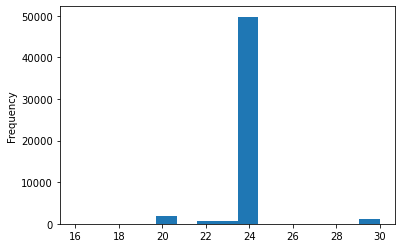

In [25]:
reads_table['barcode_length'].plot.hist(range=(16,30), bins=15)

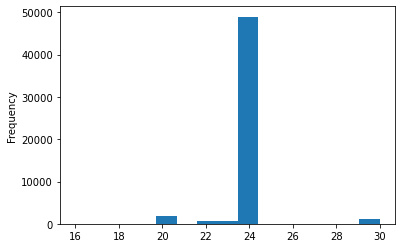

In [26]:
reads_table[reads_table['sanity']==True]['barcode_length'].plot.hist(range=(16,30), bins=15)

From here on, restrict the analysis to reads with `sanity == True`.

In [27]:
good_reads = reads_table[reads_table['sanity']==True][["forward_primer","reverse_primer","R1_barcode"]]
good_reads.columns=(["forward_primer","reverse_primer","barcode"])
good_reads["count"]=1
good_reads

,forward_primer,reverse_primer,barcode,count
0,oVK031,oVK044,CTGTCTGTGTCACAGACACTCACT,1
1,oVK025,oVK039,GACTCTGACAGTGAGAGTGAGTGA,1
2,oVK033,oVK039,CAGACTCAGTGACTGTCAGAGACA,1
3,oVK032,oVK047,GTCAGAGTGTGTGTGAGTGAGAGA,1
4,oVK034,oVK039,CAGACTCAGTGACTGTCAGAGACA,1
...,...,...,...,...
55939,oVK033,oVK044,CTGTCAGAGAGTGTCAGTGTCAGT,1
55940,oVK032,oVK026,GTCTGAGAGAGAGTCACTGTCTGA,1
55941,oVK025,oVK039,GTCTGTCTCAGTCACACACAGTGT,1
55942,oVK032,oVK041,GTCAGAGACTGAGTGTCAGACTGA,1


In [28]:
counts_table = good_reads.groupby(by=["forward_primer","reverse_primer","barcode"]).size().reset_index(name="count").sort_values(['forward_primer','reverse_primer','count'], ascending=[True,True,False])
counts_table.columns=["forward_primer","reverse_primer","barcode","count"]
counts_table

,forward_primer,reverse_primer,barcode,count
74,oVK025,oVK026,GTCTGTCTCAGTCACACACAGTGT,772
91,oVK025,oVK026,GTGTCTGAGTGACTGAGAGT,83
67,oVK025,oVK026,GTCTGAGAGAGAGTCACTGTCTGA,70
48,oVK025,oVK026,GAGAGAGAGTCAGACACACAGTCA,68
97,oVK025,oVK026,GTGTGTCAGAGAGACAGAGACTCT,68
...,...,...,...,...
5765,oVK035,oVK048,GTGAGTGAGTGTGAGACTGACTCA,1
5768,oVK035,oVK048,GTGTCTGTGAGAGAGACTCACAGA,1
5772,oVK035,oVK048,GTGTGTGTCTCTGTCACTGTGTCT,1
5773,oVK035,oVK048,GTGTGTGTGAAAGAGAGAGAGAGT,1


In [29]:
little_counts_table = counts_table.groupby(by=["forward_primer","reverse_primer"]).nth(list(range(10))).reset_index()
little_counts_table

,forward_primer,reverse_primer,barcode,count
0,oVK025,oVK026,GTCTGTCTCAGTCACACACAGTGT,772
1,oVK025,oVK026,GTGTCTGAGTGACTGAGAGT,83
2,oVK025,oVK026,GTCTGAGAGAGAGTCACTGTCTGA,70
3,oVK025,oVK026,GAGAGAGAGTCAGACACACAGTCA,68
4,oVK025,oVK026,GTGTGTCAGAGAGACAGAGACTCT,68
...,...,...,...,...
715,oVK035,oVK048,CTGACTGACACTCTGTCAGTCACA,10
716,oVK035,oVK048,GTCTGTCAGTGACTGTCTGAGTCA,6
717,oVK035,oVK048,GTGAGTGAGAGTCACTGTGAGACT,6
718,oVK035,oVK048,GAGAGAGAGTCAGACACACAGTCA,5


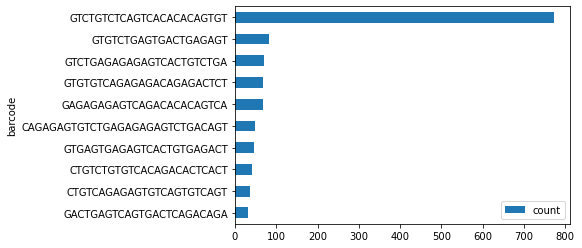

In [30]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK025') & 
    (little_counts_table['reverse_primer']=='oVK026')].sort_values("count").plot.barh(x="barcode",y="count")

[Text(0, 0.5, '')]

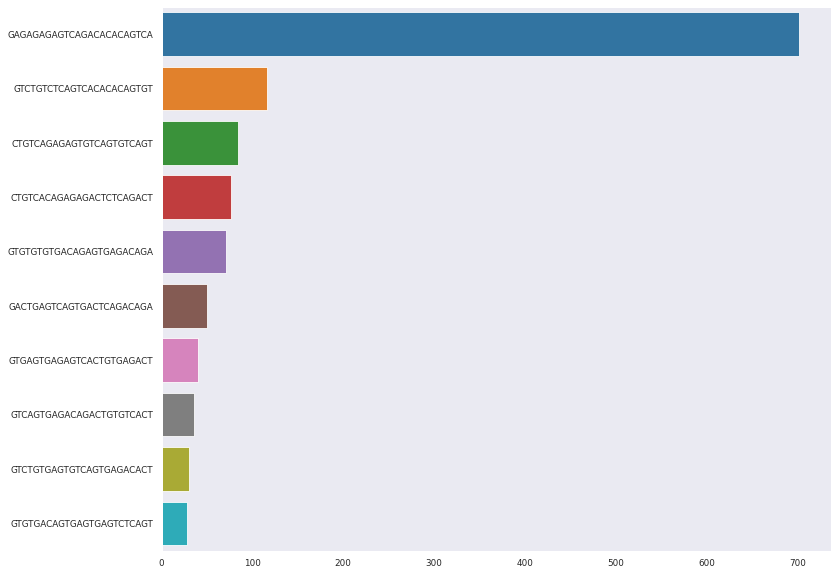

In [31]:
sns.set_style("dark")
sns.set_context("paper")
f, ax = plt.subplots()
f.set_size_inches(12,10)
g = sns.barplot(
        y = "barcode",
        x = "count",
        data=little_counts_table[
            (little_counts_table['forward_primer']=='oVK025') & 
            (little_counts_table['reverse_primer']=='oVK039')].sort_values("count", ascending=False).head(10),
        orient='h', ax=ax
)
g.set(xlabel=None)
g.set(ylabel=None)

Text(0.5, 0.98, 'VK003')

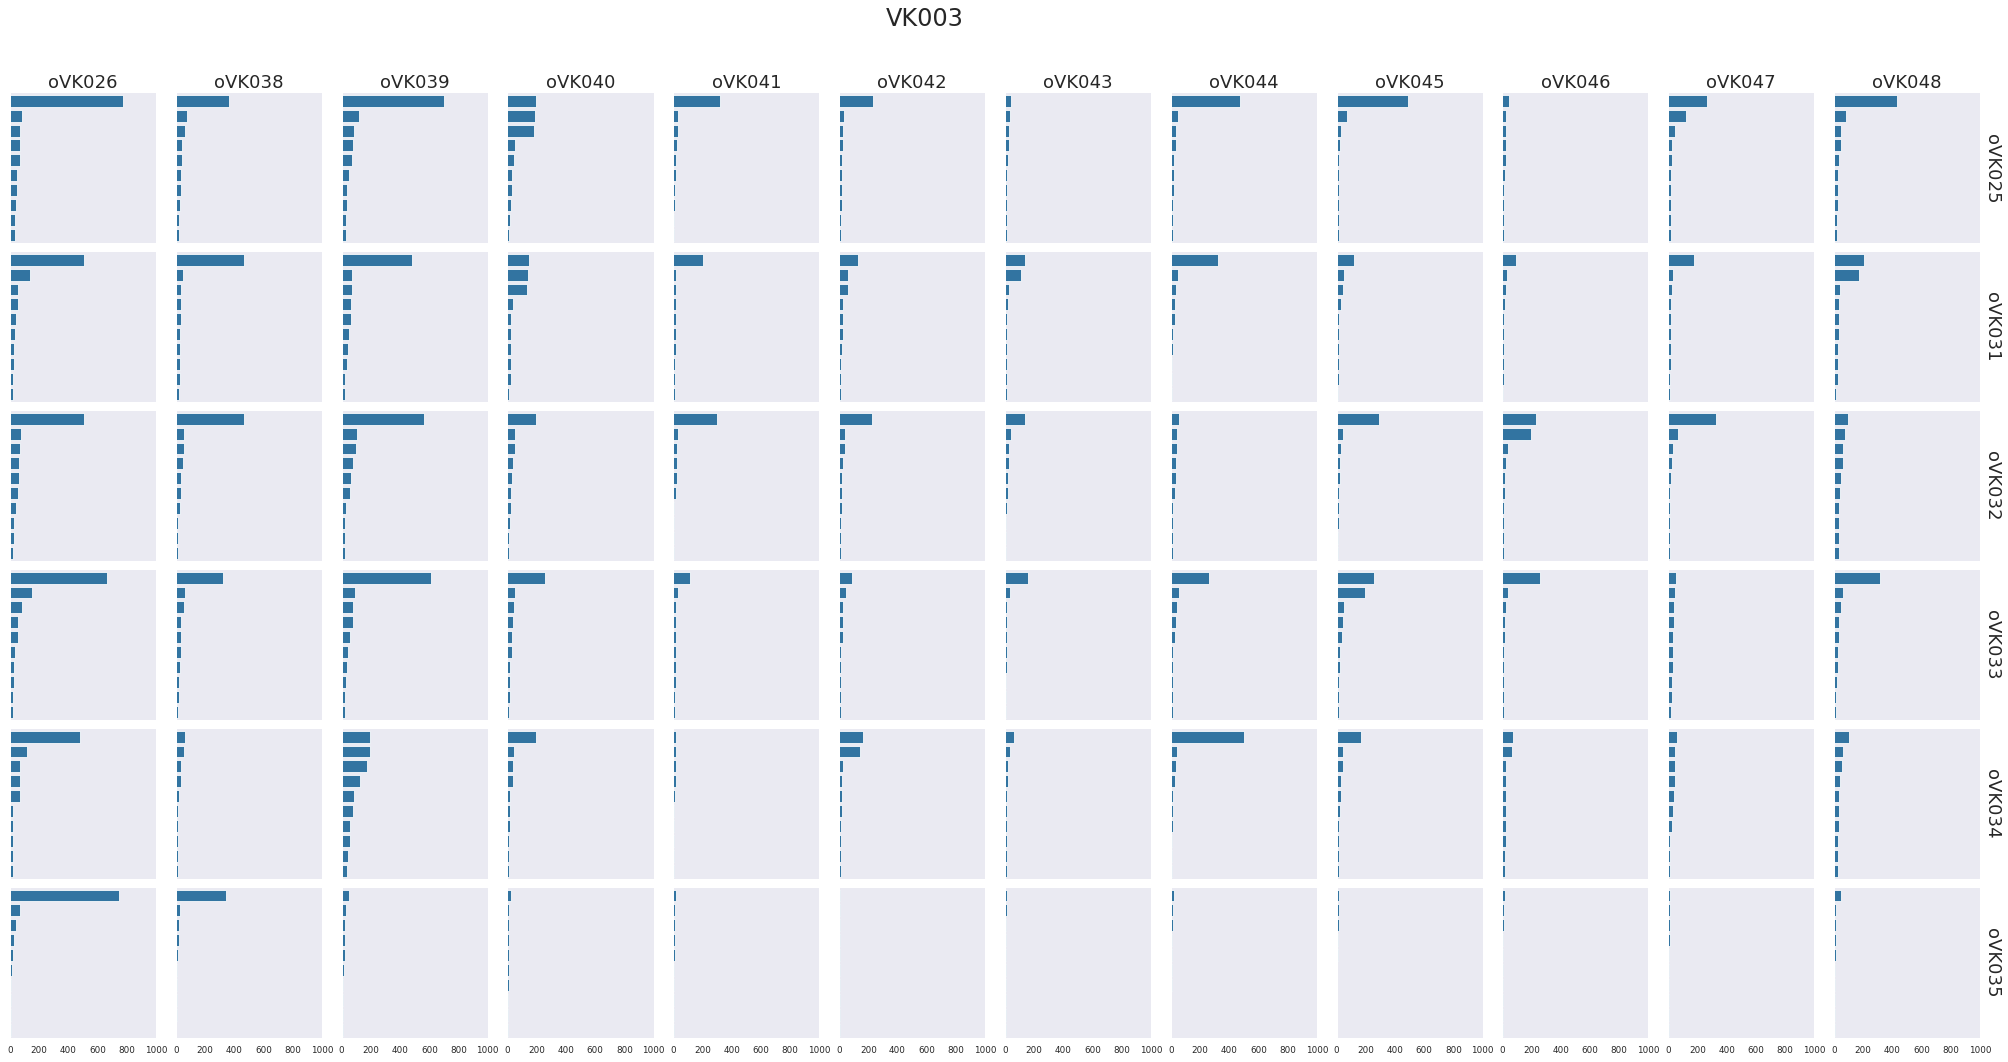

In [32]:
sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g2 = sns.FacetGrid(little_counts_table, row="forward_primer", col="reverse_primer", height=2.5, aspect=1 ,margin_titles=True)
g2.map_dataframe(sns.barplot,x="count",y="barcode", orient='h')
g2.set_yticklabels(None)
g2.set_xticklabels(None)
g2.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
plt.subplots_adjust(top=0.9)
g2.fig.suptitle("VK003", fontsize=24)

In [33]:
little_counts_table[
    (little_counts_table['forward_primer']=='oVK025') & 
    (little_counts_table['reverse_primer']=='oVK043')].sort_values("count",ascending=False)

,forward_primer,reverse_primer,barcode,count
60,oVK025,oVK043,GTCTGTCTCAGTCACACACAGTGT,41
61,oVK025,oVK043,GTGAGTGTCTGTGACTGAGTCTCT,34
62,oVK025,oVK043,GAGAGAGAGTCAGACACACAGTCA,26
63,oVK025,oVK043,CTGTGTCTGTGAGTCTGTGAGAGT,25
64,oVK025,oVK043,GTGTCAGTCTGTGTGTCTGAGAGT,24
65,oVK025,oVK043,CTGTCTGTGTCACAGACACTCACT,16
66,oVK025,oVK043,GACTGAGTCAGTGACTCAGACAGA,13
67,oVK025,oVK043,GTGTGTCAGAGAGACAGAGACTCT,13
68,oVK025,oVK043,CAGTCTCTCACAGAGTCACAGACT,12
69,oVK025,oVK043,GAGTGTGAGTCACAGTGAGTCAGT,12


/opt/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


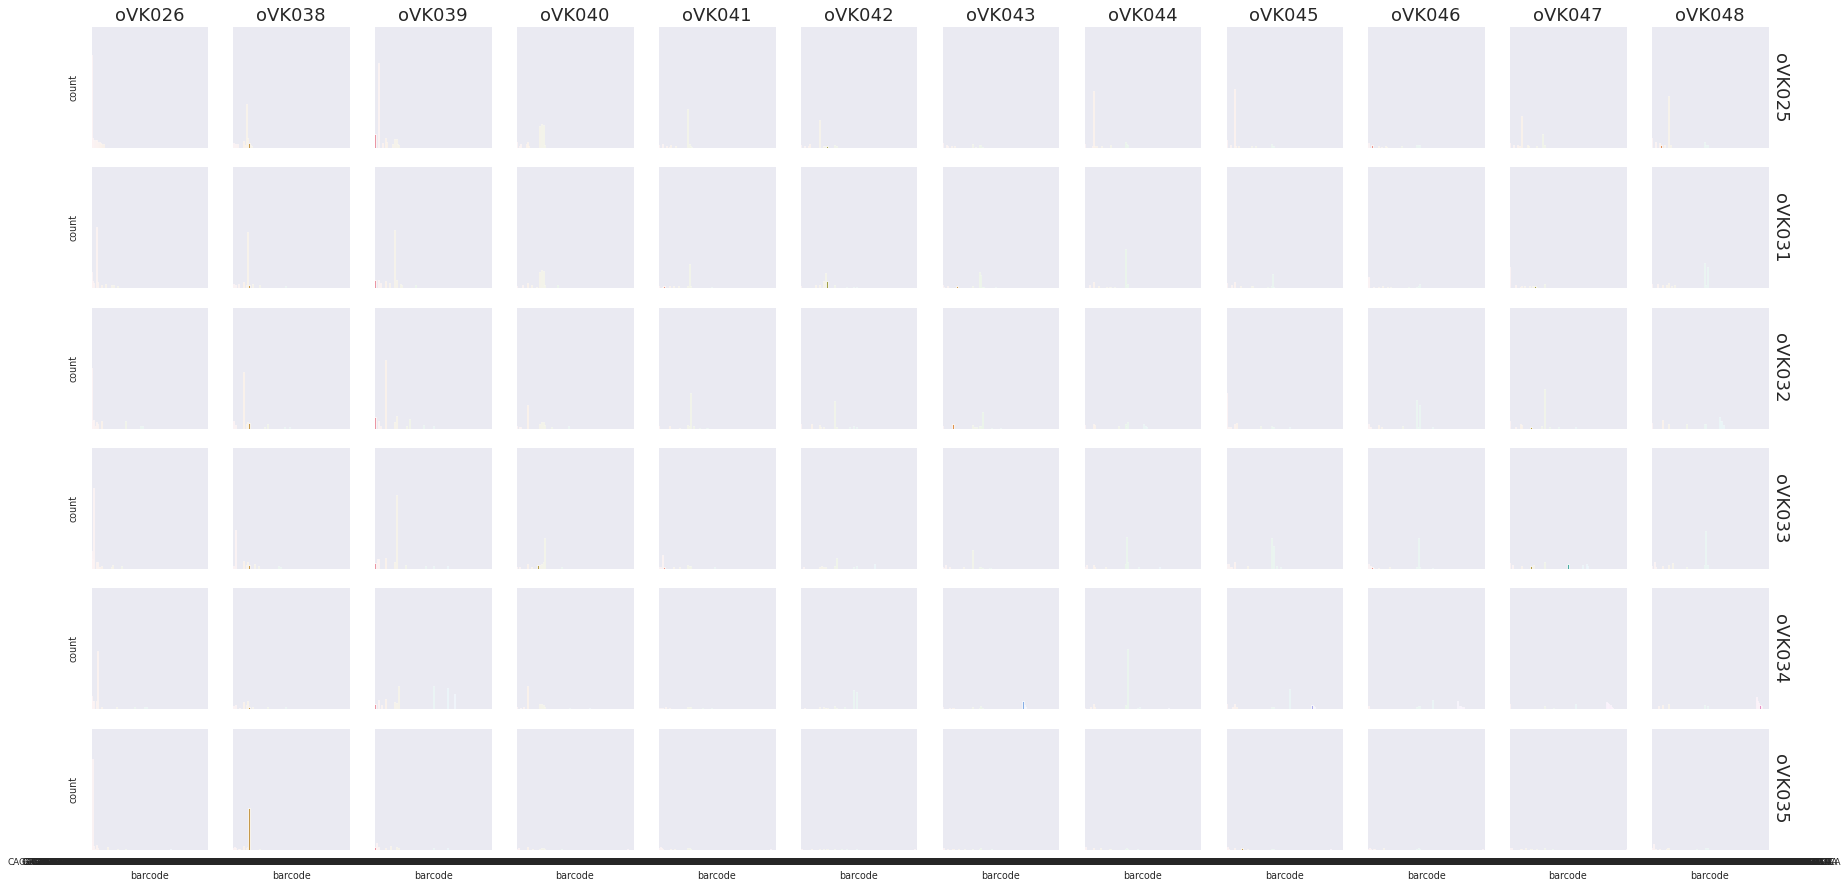

In [48]:
# Not working
# Trying to use seaborn.catplot

sns.set_style()
sns.set_style("dark")
sns.set_context("paper")
g3 = sns.catplot(
    x="barcode", 
    y="count",
    col="reverse_primer",
    row="forward_primer",
    data=little_counts_table, 
    kind="bar",
    height=2, aspect=1,
    margin_titles=True
)
g3.set_xticklabels(None)
g3.set_yticklabels(None)
g3.set_xlabels(None)
g3.set_ylabels(None)
g3.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)

In [34]:
little_counts_table.to_csv("little_counts_table.csv")

# A Bunch of Stuff I Don't Want to Get Rid of Yet

In [ ]:
def PrintSeqSingleRow(n, direction, table):
    read = table.iloc[n]
    if direction == 'R1':
        intervals = [
                [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
                [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
                read['R1_barcode_loc']
            ]
        sequence = read['R1_sequence']
    elif direction == 'R2':
        intervals = [
                [read['R2_fwd_primer_loc'], read['R2_fwd_primer_loc'] + primer_lookup[read['R2_fwd_primer']]['len'] ],
                [read['R2_rc_primer_loc'], read['R2_rc_primer_loc'] + primer_lookup[read['R2_rc_primer']]['len']],
                read['R2_barcode_loc']
            ]
        sequence = read['R2_sequence']
    else:
        return ""
    # print(intervals)
    highlights = ColorSeq(sequence, intervals)
    return highlights

In [ ]:
for i in range(25):
    print( "{0:4d} {1[R1_fwd_direction]} {1[R1_rc_direction]} {2:4d} {3:4d}".format(
        i, reads_table.iloc[i], len(reads_table.iloc[i]['R1_sequence']), len(reads_table.iloc[i]['R2_sequence'])) )

In [ ]:
def PrintSeqMultiRow(n, table):
    read = table.iloc[n]
    highlights = ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_fwd_primer_loc'], read['R1_fwd_primer_loc'] + primer_lookup[read['R1_fwd_primer']]['len'] ],
            [read['R1_rc_primer_loc'], read['R1_rc_primer_loc'] + primer_lookup[read['R1_rc_primer']]['len']],
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'], read['R1_pre_loc'] + len(reference_sequence_pre) ],
            [read['R1_post_loc'], read['R1_post_loc'] + len(reference_sequence_post) ]
        ]
    )
    highlights += '\n' + ColorSeq(
        read['R1_sequence'],
        [
            [read['R1_pre_loc'] + len(reference_sequence_pre), read['R1_post_loc']]
        ]
    )
    return highlights

In [ ]:
h=PrintSeqMultiRow(1, reads_table)
print(h)

In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', reads_table.iloc[i]['sequence'])
    print()

In [ ]:
from colored import bg, fg, attr
from itertools import chain

def SplitString(s, indices):
    return [s[i:j] for (i,j) in zip( indices[:-1], indices[1:] ) ]

def InsertCodes(s, code_tuples, default_code=bg(0)+fg(15)):
    code_tuples.sort()
    indices = [0] + [i[0] for i in code_tuples] + [len(s)]
    codes = [i[1] for i in code_tuples] + [default_code]
    substrings = SplitString(s, indices)
    return default_code + ''.join( chain(*zip(substrings,codes)) )

def DisplayRow(row):
    display_string = row['R1_sequence']
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (row['R1_fwd_primer_loc'], bg('light_gray')),
        (row['R1_fwd_primer_loc']+primer_lookup[ row['R1_fwd_primer'] ]['len'], default_bg),
        # reverse primer
        (row['R1_rc_primer_loc'], bg('light_gray')),
        (row['R1_rc_primer_loc']+primer_lookup[ row['R1_rc_primer'] ]['len'], default_bg),
        # pre-flanking sequence
        (row['R1_pre_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (row['R1_post_loc'], attr('bold')+fg('navy_blue')),
        (row['R1_post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if row['R1_fwd_direction']=='F':
        # barcode
        color_codes += [
            (row['R1_pre_loc']+len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (row['R1_post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (row['R1_post_loc']+len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (row['R1_pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# following not done: need to take out the R1 and pass in 'fwd_primer_loc', etc
def DisplaySeq(seq, locations):
    display_string = seq
    default_fg = fg('white')
    default_bg = bg('black')
    color_codes=[
        (0, default_fg + default_bg),
        # forward primer
        (locations['fwd_primer_loc'], bg('dark_gray')),
        (locations['fwd_primer_loc'] + locations['fwd_primer_len'], default_bg),
        # reverse primer
        (locations['rc_primer_loc'], bg('dark_gray')),
        (locations['rc_primer_loc'] + locations['rc_primer_len'], default_bg),
        # pre-flanking sequence
        (locations['pre_loc'], attr('bold')),
        (locations['pre_loc']+len(reference_sequence_pre), attr('res_bold')+default_fg),
        # post-flanking sequence
        (locations['post_loc'], attr('bold')),
        (locations['post_loc']+len(reference_sequence_post), attr('res_bold')+default_fg),
        ]
    if locations['direction']=='F':
        # barcode
        color_codes += [
            (locations['pre_loc'] + len(reference_sequence_pre), fg('light_blue')+bg('grey_85')),
            (locations['post_loc'], default_fg + default_bg)
        ]
    else:
        # barcode
        color_codes += [
            (locations['post_loc'] + len(reference_sequence_post), fg('light_blue')+bg('grey_85')),
            (locations['pre_loc'], default_fg + default_bg)
        ]
    return InsertCodes(display_string, color_codes)

# Need to reverse the direction for 'R' reads
def DisplayRowWithDirection(row, read):
    # row is a row of reads_table
    # read = 1 or 2
    if read == 1:
        readchar = 'R1'
    else:
        readchar = 'R2'
    if row[readchar + '_fwd_direction'] == 'F':
        direction = 'F'
        seq = row[readchar + '_sequence']
        postrx = lambda x: x
    else:
        direction = 'R'
        seq = row[readchar + '_sequence'][::-1]
        l = len(seq)
        postrx = lambda x: l - 1 - x # not working
    
    locations = {
        'fwd_primer_loc':postrx( row[readchar + '_fwd_primer_loc'] ),
        'fwd_primer_len':primer_lookup[ row[readchar + '_fwd_primer'] ]['len'],
        'rc_primer_loc':postrx( row[readchar + '_rc_primer_loc'] ),
        'rc_primer_len':primer_lookup[ row[readchar + '_rc_primer'] ]['len'],
        'pre_loc':postrx( row[readchar + '_pre_loc'] ),
        'post_loc':postrx( row[readchar + '_post_loc'] ),
        'fwd_primer':row[readchar + '_fwd_primer'],
        'rc_primer':row[readchar + '_rc_primer']
    }
    locations['direction']=direction,
    
    return DisplaySeq(seq, locations)

In [ ]:
print(
    DisplayRow( reads_table.iloc[1] )
)
print(
    DisplayRow( reads_table.iloc[2] )
)
print(
    DisplayRow( reads_table.iloc[3] )
)

In [ ]:
print(
    DisplayRowWithDirection( reads_table.iloc[1], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[1], 2 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 1 )
)
print(
    DisplayRowWithDirection( reads_table.iloc[2], 2 )
)

In [ ]:
with open('reads.txt', 'w') as f:
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[1], 2 ) + '\n\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 1 ) + '\n' )
    f.write( DisplayRowWithDirection( reads_table.iloc[2], 2 ) + '\n' )


In [ ]:
for i in range(25):
    print( "{0:4d} {2:4d} {1}".format(i, reads_table.iloc[i]['R1_fwd_direction'], len(reads_table.iloc[i]['R1_sequence'])), PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqSingleRow(i, 'R1', reads_table) )
    print( 11*' ', PrintSeqOriented(i, reads_table) )
    print()

In [35]:
conda install -c conda-forge colored 

Solving environment: done

## Package Plan ##

  environment location: /opt/miniconda

  added / updated specs:
    - colored


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_1         143 KB  conda-forge
    colored-1.4.2              |             py_0          15 KB  conda-forge
    conda-4.9.2                |   py37h89c1867_0         3.0 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTALLED:

  colored            conda-forge/noarch::colored-1.4.2-py_0
  python_abi         conda-forge/linux-64::python_abi-3.7-1_cp37m

The following packages will be UP